<a href="https://colab.research.google.com/github/Chizuchizu/student_cup_chizuchizu/blob/master/notebooks/main2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 6.7MB/s 
     |████████████████████████████████| 3.0MB 19.0MB/s 
     |████████████████████████████████| 890kB 44.8MB/s 
     |████████████████████████████████| 1.1MB 40.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=4a6aa3afd47dc15016ac33b959a221af993d938af3ad122a646fd6c26cf5b60e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd
import torch
import re
# from transformers.modeling_bert import BertModel
from transformers import BertTokenizer, BertForPreTraining, BertModel,BertForSequenceClassification
from transformers import BartTokenizer, BartModel
from sklearn.metrics import precision_score
import torch
from torch import nn
import json
import torchtext
import string
import random
import sys
import re
import pandas as pd
import numpy as np
import gc
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb
from matplotlib_venn import venn2
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import NMF,LatentDirichletAllocation,TruncatedSVD

In [34]:
SEED_VALUE = 1234 
# os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
torch.manual_seed(SEED_VALUE) 

In [35]:
df_train = pd.read_csv('/content/drive/My Drive/data/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/data/test.csv')

In [36]:
df_train['jobflag'] = df_train['jobflag']-1
df_train['jobflag'].value_counts()

2    1376
0     624
3     583
1     348
Name: jobflag, dtype: int64

In [37]:
yy = df_train['jobflag'].values
weight = 1 / pd.DataFrame(yy).reset_index().groupby(0).count().values
# weight = weight[train_y].ravel()
# weight /= weight.sum()

In [38]:
import numpy as np
del df_train['id']
df_train.drop_duplicates(subset='description', keep='last', inplace=True)
df_train = df_train.reset_index(drop=True)
df_train['id'] = np.arange(2905)
df_train

,description,jobflag,id
0,"Executes and writes portions of testing plans,...",1,0
1,Maintain Network Performance by assisting with...,2,1
2,Supports the regional compliance manager with ...,3,2
3,Keep up to date with local and national busine...,0,3
4,Assist with Service Organization Control (SOC)...,3,4
...,...,...,...
2900,Preparation of reports for operational and man...,2,2900
2901,Line and/or indirect management of up to 20 st...,2,2901
2902,Partner with external agencies as needed,0,2902
2903,"Design, Implement and test software for embedd...",2,2903


## tokenizer and preprocessing

In [39]:
tokenizer_bert = BartTokenizer.from_pretrained('facebook/bart-large')
# tokenizer_bert = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocessing(text):
    text = text.lower()
    return text


def token_same_len(token):
    token.insert(0,'[CLS]')
    if len(token) < 128:
        while len(token) != 128:
            token.insert(128,'[PAD]')
    token.insert(127,'[SEP]')
    return token

def token_and_prepro(text, tokenizer = tokenizer_bert):
    text = preprocessing(text)
    token = tokenizer.tokenize(text)
    token = token_same_len(token)
    ids = tokenizer.convert_tokens_to_ids(token[:128])
    return ids

## dataset(torchtext)

In [40]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer,token_same_len):
        self.df = df
        self.tokenizer = tokenizer
        self.token_same_len = token_same_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, input_ids):
        text = self.df['description'][input_ids]
        label = self.df['jobflag'][input_ids]
        id = self.df['id'][input_ids]
        
        token = self.tokenizer(text)
        
        tensor_token = torch.tensor(token)
        tensor_label = torch.tensor(label)
        
        return tensor_token, tensor_label, id

In [41]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer,token_same_len):
        self.df = df
        self.tokenizer = tokenizer
        self.token_same_len = token_same_len
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, input_ids):
        text = self.df['description'][input_ids]
        id = self.df['id'][input_ids]
        
        token = self.tokenizer(text)
        
        tensor_token = torch.tensor(token)
        
        return tensor_token, id

In [42]:
from torch.utils.data.sampler import BatchSampler
from torch.utils.data import DataLoader
import numpy as np
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label,id in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

## dataloader

## model構築

In [43]:
# model = BertModel.from_pretrained(pretrained_model_name_or_path='bert-base-uncased')
model = BartModel.from_pretrained(pretrained_model_name_or_path='facebook/bart-large')
# model1 =BertForSequenceClassification.from_pretrained(pretrained_model_name_or_path='bert-base-uncased',num_labels=4)
# print(model1)

Some weights of the model checkpoint at facebook/bart-large were not used when initializing BartModel: ['encoder.version', 'decoder.version']
- This IS expected if you are initializing BartModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BartModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [44]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert = model
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(in_features=1024, out_features=4)
#         self.dropout = nn.Dropout(0.3)
        
        nn.init.normal_(self.classifier.weight, std=0.02)
        nn.init.normal_(self.classifier.bias, 0)
        
    def forward(self, inputs):
        output = self.bert(inputs)
        vec_0 = output[0]  
        vec_0 = vec_0[:, 0, :] 
        vec_0 = vec_0.view(-1, 1024)
        
        vec_0 = self.dropout(vec_0)
        result = self.classifier(vec_0)
        
        return result

In [81]:
bert_model = BERT()
bert_model.train()
print('a')

a


### 勾配の計算場所

In [85]:
# encoder.layer.11.output.LayerNorm.bias
# 1.勾配計算Falseにする（ALl）
for param in bert_model.parameters():
    param.requires_grad = False
# 2. BertLayer[12]そう目
for param in bert_model.bert.decoder.layers[-3:].parameters():
    param.requires_grad = True
# 3. label
for param in bert_model.classifier.parameters():
    param.requires_grad = True

### oprimzer and loss

In [86]:
from sklearn.metrics import f1_score
def metric_f1(preds, data):
    """
    F1 evaluation function for lgbm model.
    """
    y_true = data.get_label()
    preds = preds.reshape(4, len(preds) // 4)
    y_pred = np.argmax(preds, axis=0)
    score = f1_score(y_true, y_pred, average="macro")
    return "metric_f1", score, True

In [87]:
import sys
def train_model(net, dataloaders_dict, criterion, optimizer, scheduler, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    net.to(device)
    # ネットワークがある程度固定であれば、高速化させる
    torch.backends.cudnn.benchmark = True

    # ミニバッチのサイズ
    # batch_size = dataloaders_dict["train"].batch_size
    batch_size = 32
    a = 0

    for epoch in range(num_epochs):
        for phase in ['train', 'val']:
            if phase == 'train':
                net.train()
            else:
                net.eval()

            epoch_loss = 0.0
            f1_batch =0
            epoch_corrects = 0
            iteration = 1
            c = 0

            # データローダーからミニバッチを取り出すループ
            for batch in (dataloaders_dict[phase]):
                # batchはTextとLableの辞書型変数

                # GPUが使えるならGPUにデータを送る
                inputs = batch[0].to(device)  # 文章
                labels = batch[1].to(device)  # ラベル

                # optimizerを初期化
                optimizer.zero_grad()

                # 順伝搬（forward）計算
                with torch.set_grad_enabled(phase == 'train'):

                    # BERTに入力
                    outputs = net(inputs)
                    
                    loss = criterion(outputs, labels)  # 損失を計算

                    _, preds = torch.max(outputs, 1)  # ラベルを予測

                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        

                        if (iteration %  50 == 0):  # 10iterに1度、lossを表示
                            # a +=1
                            # print(a)
                            scheduler.step()
                            acc = (torch.sum(preds == labels.data)
                                   ).double()/batch_size
                            f1 = f1_score(preds.cpu().numpy(),
                                                 labels.data.cpu().numpy(),
                                                 average='macro')
                            print(' All / batch　{} || Loss: {:.4f} | ACC：{}　| F1 :{}'.format(
                                iteration, loss.item(),  acc, f1))
                    
                    

                    iteration += 1

                    # 損失と正解数の合計を更新
                    epoch_loss += loss.item() * batch_size
                    epoch_corrects += torch.sum(preds == labels.data)
                    f1_batch += f1_score(preds.to('cpu').detach().clone().numpy(), 
                                   labels.data.to('cpu').detach().clone().numpy(), 
                                   average='macro')
                    # print(f1_batch)
                    # if c ==26:
                    #     sys.exit()
                    # c +=1
                    # print(c)
                    # f1_batch += precision_score(preds.cpu().numpy(),
                    #                         labels.data.cpu().numpy(),
                    #                         average='macro')
                    # print(f1_batch)
                        
            # epochごとのlossと正解率
            epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
            epoch_acc = epoch_corrects.double(
            ) / len(dataloaders_dict[phase].dataset)
            f1s = f1_batch/ len(dataloaders_dict[phase])
            # epoch_f1 = f1_batch/len(dataloaders_dict[phase].dataset)
            ##########lineに送信##########################
            if phase != 'train':
                url = "https://notify-api.line.me/api/notify"
                token = 'tQSMjodBp3mHEA6wGscIofzVyDUquKliy6diNv5eP78'
                headers = {"Authorization" : "Bearer "+ token}
                message =  'Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}'.format(epoch+1, num_epochs,
                                                                            phase, epoch_loss, epoch_acc)
                payload = {"message" :  message}
                r = requests.post(url ,headers = headers ,params=payload)
            ###############################################
            print('Epoch {}/{} | {:^5} |  Loss: {:.4f} Acc: {:.4f}  F1  :  {}'.format(epoch+1, num_epochs,
                                                                           phase, epoch_loss, epoch_acc,f1s))

    return net

In [88]:
df_train['jobflag'].value_counts()

2    1364
0     622
3     579
1     340
Name: jobflag, dtype: int64

In [89]:

import torch.optim as optim


# BERTの元の部分はファインチューニング
optimizer = optim.Adam([
    {'params': bert_model.bert.encoder.layers[-1].parameters(), 'lr': 1e-2},
    {'params': bert_model.classifier.parameters(), 'lr': 1e-2}
])
# weight decacyなし
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size =2, gamma = 0.9)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3,4,6], gamma=0.5)
# 損失関数の設定
# weights = torch.tensor(weight).cuda()
# print(weights)
# weights = torch.tensor([2.192926045016077,4.011764705882353,1.0,2.3557858376511227]).cuda()
weight = len(df_train) / df_train["jobflag"].value_counts().sort_index().values
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weights = torch.tensor(weight.tolist()).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss(weight=weights)
# criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiMarginLoss()

In [90]:
# del df_test['id']
import sys
dataset = Dataset(df = df_train, tokenizer = token_and_prepro,token_same_len=token_same_len)
test_dataset = TestDataset(df = df_test, tokenizer = token_and_prepro,token_same_len=token_same_len)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])
# train_sampler = BalancedBatchSampler(train_dataset, 4, 8)
#train
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_sampler)
train_dataloader = torch.utils.data.DataLoader(train_dataset,  batch_size= 32, shuffle=True)
#val
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size= 32, shuffle=False)
#test
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)
#loader_dict
load_dict = {"train":train_dataloader, 'val':val_dataloader,'test':dl_test}

In [ ]:
import requests
num_epochs = 13
net_trained = train_model(bert_model, 
                          load_dict,
                          criterion, 
                          optimizer, 
                          scheduler,
                          num_epochs=num_epochs)
#save
torch.save(net_trained.state_dict(), 'model.pth')
#load
# the_model = TheModelClass(*args, **kwargs)
# the_model.load_state_dict(torch.load('model.pth'))

## 誤差分析

In [ ]:
from tqdm import tqdm
def make_df(phase):
    preds_list = []
    label_list = []
    outputs1_list = []
    outputs2_list = []
    outputs3_list = []
    outputs4_list = []
    id_list = []
    df_error = pd.DataFrame()
    df_errors = pd.DataFrame()


    if phase == 'test':
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bert_model.eval()
        bert_model.to(device)
        for batch in tqdm(load_dict[phase]): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            inputs = batch[0].to(device)
            id_list.extend(batch[1].to('cpu').detach().clone().numpy())
            
            with torch.set_grad_enabled(False):
                outputs_ = net_trained(inputs)
                # loslogits = outputs
                _, preds = torch.max(outputs_, 1)  # ラベルを予測
                preds_list.extend(preds.to('cpu').detach().clone().numpy())
                outputs = torch.t(outputs_).to('cpu').detach().clone().numpy()
                outputs1_list.extend(outputs[0])
                outputs2_list.extend(outputs[1])
                outputs3_list.extend(outputs[2])
                outputs4_list.extend(outputs[3])
                # label_list.extend(labels.to('cpu').detach().clone().numpy())
                df_error = pd.DataFrame({'prob0':outputs1_list,
                                'prob1':outputs2_list,
                                'prob2':outputs3_list,
                                'prob3':outputs4_list,
                                'id':id_list,
                                'pred':preds_list})
        df_errors = pd.merge(df_error, df_test, on='id')
        body_len = []
        # print('a')
        for i in df_errors['description']:
            body_len.append(len(i))
        df_errors['len'] = body_len
        train_x = df_errors[['id','prob0','prob1','prob2','prob3','pred','description']]
        return train_x
    
    else:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        bert_model.eval()
        bert_model.to(device)
        for batch in tqdm(load_dict[phase]): 
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            inputs = batch[0].to(device)
            id_list.extend(batch[2].to('cpu').detach().clone().numpy())
            labels = batch[1].to(device) 
            
            with torch.set_grad_enabled(False):
                outputs_ = net_trained(inputs)
                # loslogits = outputs
                _, preds = torch.max(outputs_, 1)  # ラベルを予測
                preds_list.extend(preds.to('cpu').detach().clone().numpy())
                outputs = torch.t(outputs_).to('cpu').detach().clone().numpy()
                outputs1_list.extend(outputs[0])
                outputs2_list.extend(outputs[1])
                outputs3_list.extend(outputs[2])
                outputs4_list.extend(outputs[3])
                label_list.extend(labels.to('cpu').detach().clone().numpy())
                
        df_error = pd.DataFrame({'prob0':outputs1_list,
                                'prob1':outputs2_list,
                                'prob2':outputs3_list,
                                'prob3':outputs4_list,
                                'id':id_list,
                                'label':label_list,
                                'pred':preds_list})
        df_errors = pd.merge(df_error, df_train, on='id')
        body_len = []
        # print('a')
        for i in df_errors['description']:
            body_len.append(len(i))
        df_errors['len'] = body_len
        train_x = df_errors[['id','prob0','prob1','prob2','prob3','pred']]
        train_y = df_errors['label']
        return train_x, train_y

In [ ]:
val_x, val_y = make_df('val')
# train_x, train_y = make_df('train')
# test_x = make_df('test')
print(f1_score(val_y, val_x['pred'], average='macro'))
url = "https://notify-api.line.me/api/notify"
token = 'tQSMjodBp3mHEA6wGscIofzVyDUquKliy6diNv5eP78'
headers = {"Authorization" : "Bearer "+ token}
message =  f1_score(val_y, val_x['pred'], average='macro')
payload = {"message" :  message}
r = requests.post(url ,headers = headers ,params=payload)

100%|██████████| 19/19 [00:02<00:00,  7.45it/s]


0.5663724766969749


## submit用(only bert)


In [ ]:

import collections
import datetime


def submit_csv(test_id, preds_list,device):
    dt_now = datetime.datetime.now()
    time = dt_now.strftime('%Y年%m月%d日 %H:%M:%S')
    label_list = []
    if device == 'cpu':
        preds = list(map(lambda x: x+1, preds))
        submit = pd.DataFrame({'id':test_id,'pred':preds})
        submit.to_csv('submit.csv',index=False, header=False)
        print('完了cpu')
    else:
        for  i in preds_list:
            labels = i.to('cpu').detach().numpy().copy()
            label_list.extend(labels)
        label_list = list(map(lambda x: x+1, label_list))
        submit = pd.DataFrame({'id':test_id,'pred':label_list})
        submit.to_csv('1_{}.csv'.format(time),index=False, header=False)
        c = collections.Counter(label_list)
        url = "https://notify-api.line.me/api/notify"
        token = 'tQSMjodBp3mHEA6wGscIofzVyDUquKliy6diNv5eP78'
        headers = {"Authorization" : "Bearer "+ token}
        message =  'bert only',c
        payload = {"message" :  message}
        r = requests.post(url ,headers = headers ,params=payload)
        print(c)
        print('完了GPU')

In [ ]:
from tqdm import tqdm
preds_list = []
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

bert_model.eval()
bert_model.to(device)


for batch in tqdm(load_dict['test']): 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    inputs = batch[0].to(device)  
    
    with torch.set_grad_enabled(False):
        outputs = net_trained(inputs)
        # loslogits = outputs
        _, preds = torch.max(outputs, 1)  # ラベルを予測
        preds_list.append(preds)

100%|██████████| 55/55 [00:06<00:00,  8.30it/s]


In [ ]:
test_id = df_test['id'].to_list()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
label_list = submit_csv(test_id, preds_list,device)

Counter({3: 689, 4: 436, 1: 421, 2: 197})
完了GPU


## lgb(tf-idf)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
n_comp = 20
vec_count = TfidfVectorizer()
vec = pd.concat([df_train['description'],df_test['description']])
x = vec_count.fit_transform(vec)
tf_df = pd.DataFrame(x.toarray(), columns=vec_count.get_feature_names())
text_svd = TruncatedSVD(n_components=n_comp, algorithm='arpack',random_state=1234)
df_svd = pd.DataFrame(text_svd.fit_transform(tf_df))
df_svd.columns = ['svd_'+str(j+1) for j in range(n_comp)]
use_cols = []
# for col in tf_df.columns:
#     if tf_df.shape[0]*0.0025<tf_df[col].sum()<tf_df.shape[0]*0.5:
#         use_cols.append(col)
# tf_df = tf_df[use_cols]
train_tf =df_svd[:2905]
train_tf['id'] =np.arange(len(df_train))
test_tf = df_svd[2905:]
test_tf['id'] =np.arange(2931,4674)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_X = pd.merge(train_x,train_tf, on = 'id')
val_X = pd.merge(val_x, train_tf, on = 'id')
test_X = pd.merge(test_x, test_tf, on = 'id')

In [ ]:
test_id = test_X['id']
del test_X['id']
del test_X['description']
del train_X['id']
del val_X['id']

In [ ]:
# cv = KFold(n_splits=5, shuffle = True, random_state=1234)
# params = {
#     'boosting_type': 'gbdt',
#     'metric': 'multi_error',
#     'objective': 'multiclass',
#     'seed': 20,
#     'learning_rate': 0.001,
#     "n_jobs": -1,
#     "verbose": -1,
#     'num_class': 4
# }
SEED  =1234
params = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'custom',
        'learning_rate': 0.005,
        'max_depth': 5,
        'num_leaves': 31,
        'max_bin': 31,
        'min_data_in_leaf': 3,
        'verbose': -1,
        'seed': SEED,
        'drop_seed': SEED,
        'data_random_seed':SEED
    }


In [ ]:
y_value = train_y.values 
weight = 1 / pd.DataFrame(y_value).reset_index().groupby(0).count().values
weight = weight[y_value].ravel()
weight /= weight.sum()

In [ ]:
train_set = lgb.Dataset(train_X, train_y,weight=weight)
# train_set = lgb.Dataset(train_X, train_y)
val_set = lgb.Dataset(val_X,val_y)
lgb_model = lgb.train(params, train_set,num_boost_round=10000, early_stopping_rounds=2500,
                      valid_sets = [train_set, val_set], verbose_eval = 500, feval =metric_f1)

y_pred = lgb_model.predict(val_X)
y_pred = np.argmax(y_pred, axis=1)
print(f1_score(y_pred, val_y, average='macro'))

Training until validation scores don't improve for 2500 rounds.
[500]	training's metric_f1: 0.852428	valid_1's metric_f1: 0.572848
[1000]	training's metric_f1: 0.906463	valid_1's metric_f1: 0.572334
[1500]	training's metric_f1: 0.945309	valid_1's metric_f1: 0.584495
[2000]	training's metric_f1: 0.980046	valid_1's metric_f1: 0.584396
[2500]	training's metric_f1: 0.993484	valid_1's metric_f1: 0.575734
[3000]	training's metric_f1: 0.998264	valid_1's metric_f1: 0.579232
[3500]	training's metric_f1: 0.999132	valid_1's metric_f1: 0.58006
[4000]	training's metric_f1: 1	valid_1's metric_f1: 0.569847
Early stopping, best iteration is:
[1699]	training's metric_f1: 0.963117	valid_1's metric_f1: 0.591622
0.5916217872176991


In [ ]:
import collections
import datetime

dt_now = datetime.datetime.now()
time = dt_now.strftime('%Y年%m月%d日 %H:%M:%S')
y_pred = lgb_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
submit = pd.DataFrame({'id':test_id,'pred':y_pred +1})
submit.to_csv('submit_lgb_{}.csv'.format(time),index=False, header=False)
c = collections.Counter(y_pred +1)
url = "https://notify-api.line.me/api/notify"
token = 'tQSMjodBp3mHEA6wGscIofzVyDUquKliy6diNv5eP78'
headers = {"Authorization" : "Bearer "+ token}
message =  'lgb bert',c
payload = {"message" :  message}
r = requests.post(url ,headers = headers ,params=payload)
print(c)

Counter({3: 648, 4: 463, 1: 438, 2: 194})


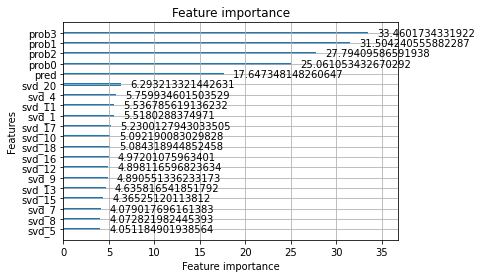

In [ ]:
lgb.plot_importance(lgb_model, importance_type="gain", max_num_features=20)

# やること
# count vector
# lossの形状
# suchadulear
#{3:610 ~ 625,4:450 ~ 500, 1:aroud 430,2,aroud 200}

In [ ]:
Counter({3: 605, 4: 509, 1: 367, 2: 262})